<a href="https://colab.research.google.com/github/pachterlab/Clytia_single_cell_2020/blob/master/notebooks/pseudotime_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!date

Sun Aug 16 22:44:27 UTC 2020


In [2]:
#Read in kallisto bus fed/starved data
!wget --quiet https://caltech.box.com/shared/static/13jsqkczkskrf6cau9p4evhnmqyp7jn3

#Starvation h5ad data, all nonzero genes included, filtered for 'real cells' from de-multiplexing
!wget --quiet https://caltech.box.com/shared/static/3l60szs0e9hgaax4q9dbuehgoo092xww

In [48]:
#Human ortholog annotations
!wget --quiet https://caltech.box.com/shared/static/slxs7968tths1xotumohnzwy6pgdtk6k

#Panther annotations
!wget --quiet https://caltech.box.com/shared/static/vx2iztm7tsyvg7rcj93h2w3hhjhn7jnt

#GO Terms
!wget --quiet https://caltech.box.com/shared/static/0ly6k9iwo1nc9dp5zxo8sw7qe0gt4oof

In [3]:
#Install packages
!pip install --quiet anndata
!pip install --quiet scanpy
!pip3 install --quiet leidenalg

!pip install --quiet louvain

     |████████████████████████████████| 122kB 2.7MB/s 
     |████████████████████████████████| 7.2MB 2.1MB/s 
     |████████████████████████████████| 51kB 4.3MB/s 
     |████████████████████████████████| 2.4MB 2.7MB/s 
     |████████████████████████████████| 3.2MB 22.7MB/s 
     |████████████████████████████████| 2.2MB 2.7MB/s 


In [4]:
#Import Packages

import random
import pandas as pd
import anndata
import scanpy as sc
import numpy as np
import scipy.sparse

import warnings
warnings.filterwarnings('ignore')

from sklearn.neighbors import (KNeighborsClassifier,NeighborhoodComponentsAnalysis)
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE

#import scrublet as scr

import matplotlib.pyplot as plt
%matplotlib inline
sc.set_figure_params(dpi=125)

import seaborn as sns
sns.set(style="whitegrid")


In [49]:
#Read in annotation data
from io import StringIO

hg_ortho_df = pd.read_csv(StringIO(''.join(l.replace('|', '\t') for l in open('slxs7968tths1xotumohnzwy6pgdtk6k'))),
            sep="\t",header=None,skiprows=[0,1,2,3])

hg_ortho_df[['XLOC','TCONS']] = hg_ortho_df[13].str.split(expand=True) 
hg_ortho_df[['Gene','gi']] = hg_ortho_df[3].str.split(expand=True) 
hg_ortho_df['Description']= hg_ortho_df[11]
#hg_ortho_df.head()

panther_df = pd.read_csv('vx2iztm7tsyvg7rcj93h2w3hhjhn7jnt',
            sep="\t",header=None) #skiprows=[0,1,2,3]

#panther_df.head()

goTerm_df = pd.read_csv('0ly6k9iwo1nc9dp5zxo8sw7qe0gt4oof',
            sep=" ",header=None) #skiprows=[0,1,2,3]

#goTerm_df.head()

In [6]:
#Read in saved data
bus_fs_combo = anndata.read('13jsqkczkskrf6cau9p4evhnmqyp7jn3')
print(bus_fs_combo)

bus_fs_raw  = anndata.read('3l60szs0e9hgaax4q9dbuehgoo092xww')
bus_fs_raw.obs['cellRanger_louvain'] = pd.Categorical(bus_fs_combo.obs['cellRanger_louvain'])
bus_fs_raw.obs['fed'] = pd.Categorical(bus_fs_combo.obs['fed'])
bus_fs_raw.obs['orgID'] = pd.Categorical(bus_fs_combo.obs['orgID'])
print(bus_fs_raw)



AnnData object with n_obs × n_vars = 13673 × 8696
    obs: 'batch', 'n_counts', 'n_countslog', 'louvain', 'leiden', 'orgID', 'fed', 'starved', 'fed_neighbor_score', 'cellRanger_louvain'
    var: 'n_counts'
    uns: 'fed_neighbor_score_colors', 'leiden', 'leiden_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'
AnnData object with n_obs × n_vars = 13673 × 46716
    obs: 'batch', 'cellRanger_louvain', 'fed', 'orgID'


In [22]:
#Subset data

#I-cells and neurons
neur_lin = bus_fs_raw[bus_fs_raw.obs['cellRanger_louvain'].isin([31,26,6,9,0])]



sc.pp.filter_cells(neur_lin, min_counts=0)
sc.pp.filter_genes(neur_lin, min_counts=1)
sc.pp.normalize_per_cell(neur_lin, counts_per_cell_after=1e4)

sc.pp.log1p(neur_lin)


sc.pp.highly_variable_genes(neur_lin, n_top_genes=2000)

neur_lin = neur_lin[:,neur_lin.var['highly_variable']]

neur_lin

#I-cells, neurons, cnidocytes, gland cells

Trying to set attribute `.obs` of view, copying.


View of AnnData object with n_obs × n_vars = 2662 × 1999
    obs: 'batch', 'cellRanger_louvain', 'fed', 'orgID', 'n_counts'
    var: 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p'

###**I-cells and Neurons**

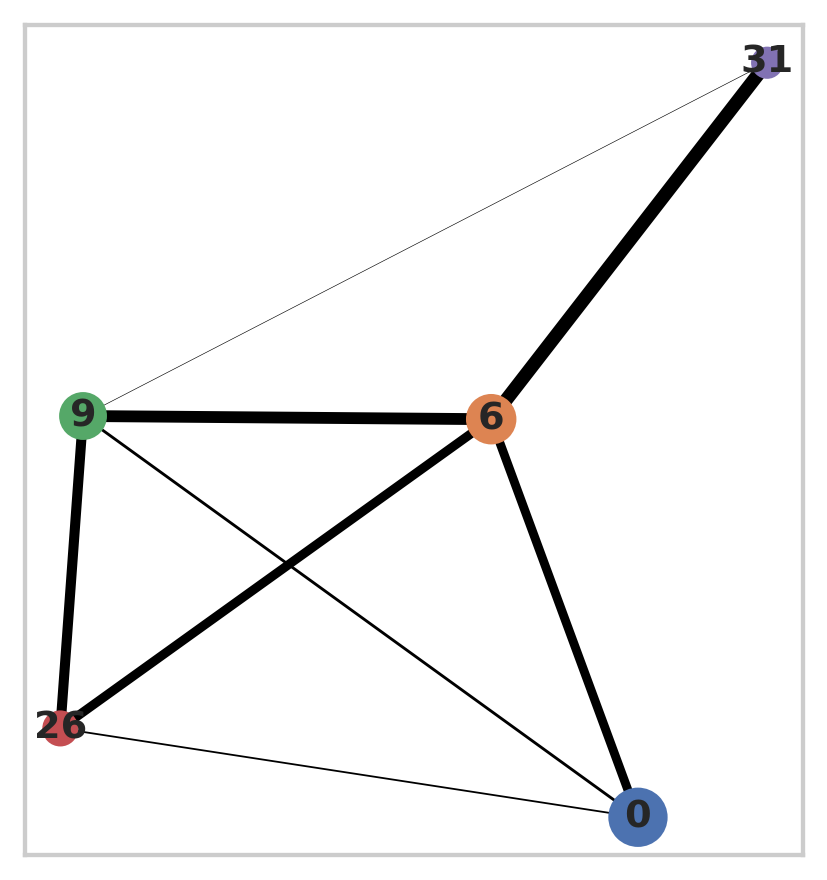

In [23]:
#I-cell + neurons PAGA embedding
neur_lin_scaled = neur_lin
sc.pp.scale(neur_lin_scaled, max_value=10)

sc.tl.pca(neur_lin_scaled, n_comps=60)
#sc.pl.pca_variance_ratio(neur_lin_scaled, log=True)

sc.pp.neighbors(neur_lin_scaled,n_neighbors=50, n_pcs=15) #n_neighbors=5, n_pcs=15,use_rep='X_nca'
sc.tl.paga(neur_lin_scaled, groups='cellRanger_louvain', )
sc.pl.paga(neur_lin_scaled, color=['cellRanger_louvain'])

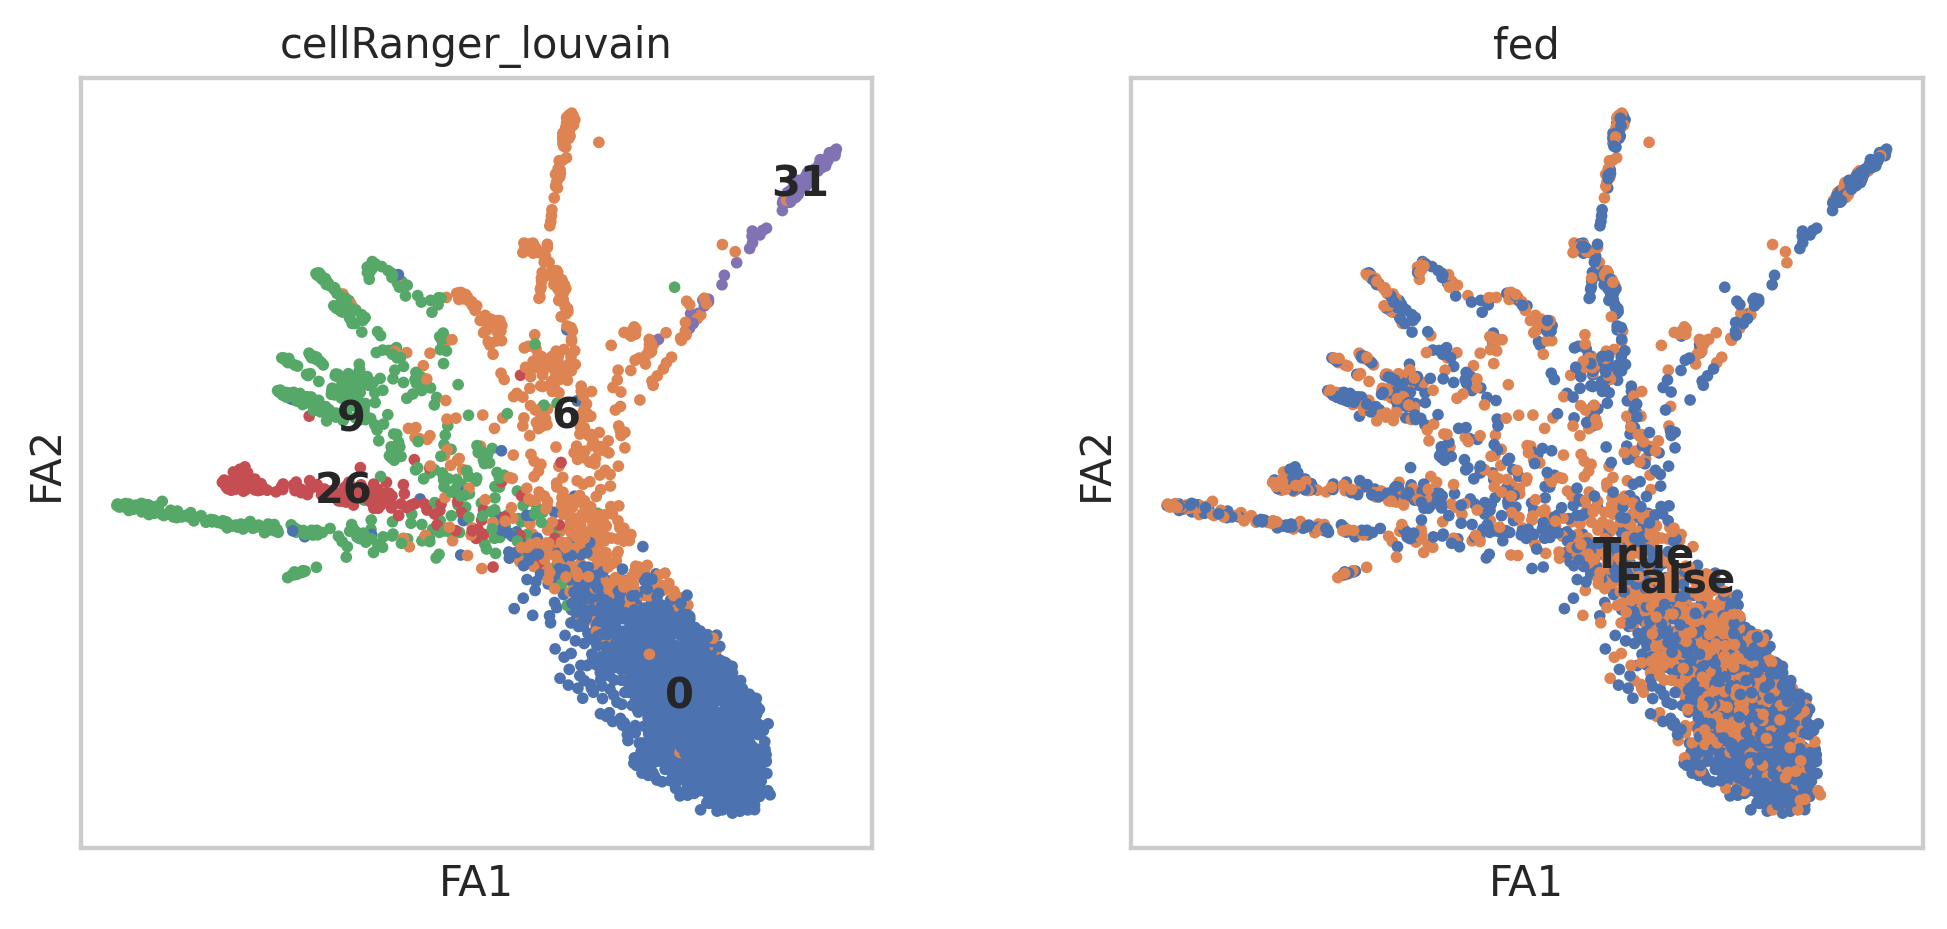

In [24]:
sc.tl.draw_graph(neur_lin_scaled, init_pos='paga')
sc.pl.draw_graph(neur_lin_scaled, color=['cellRanger_louvain','fed'], legend_loc='on data',color_map='viridis')

In [25]:
#Calculate pseudotime with diffusion components (dim reduction)

neur_lin_scaled.uns['iroot'] = np.flatnonzero(neur_lin_scaled.obs['cellRanger_louvain']  == 0)[0]
sc.tl.dpt(neur_lin_scaled)

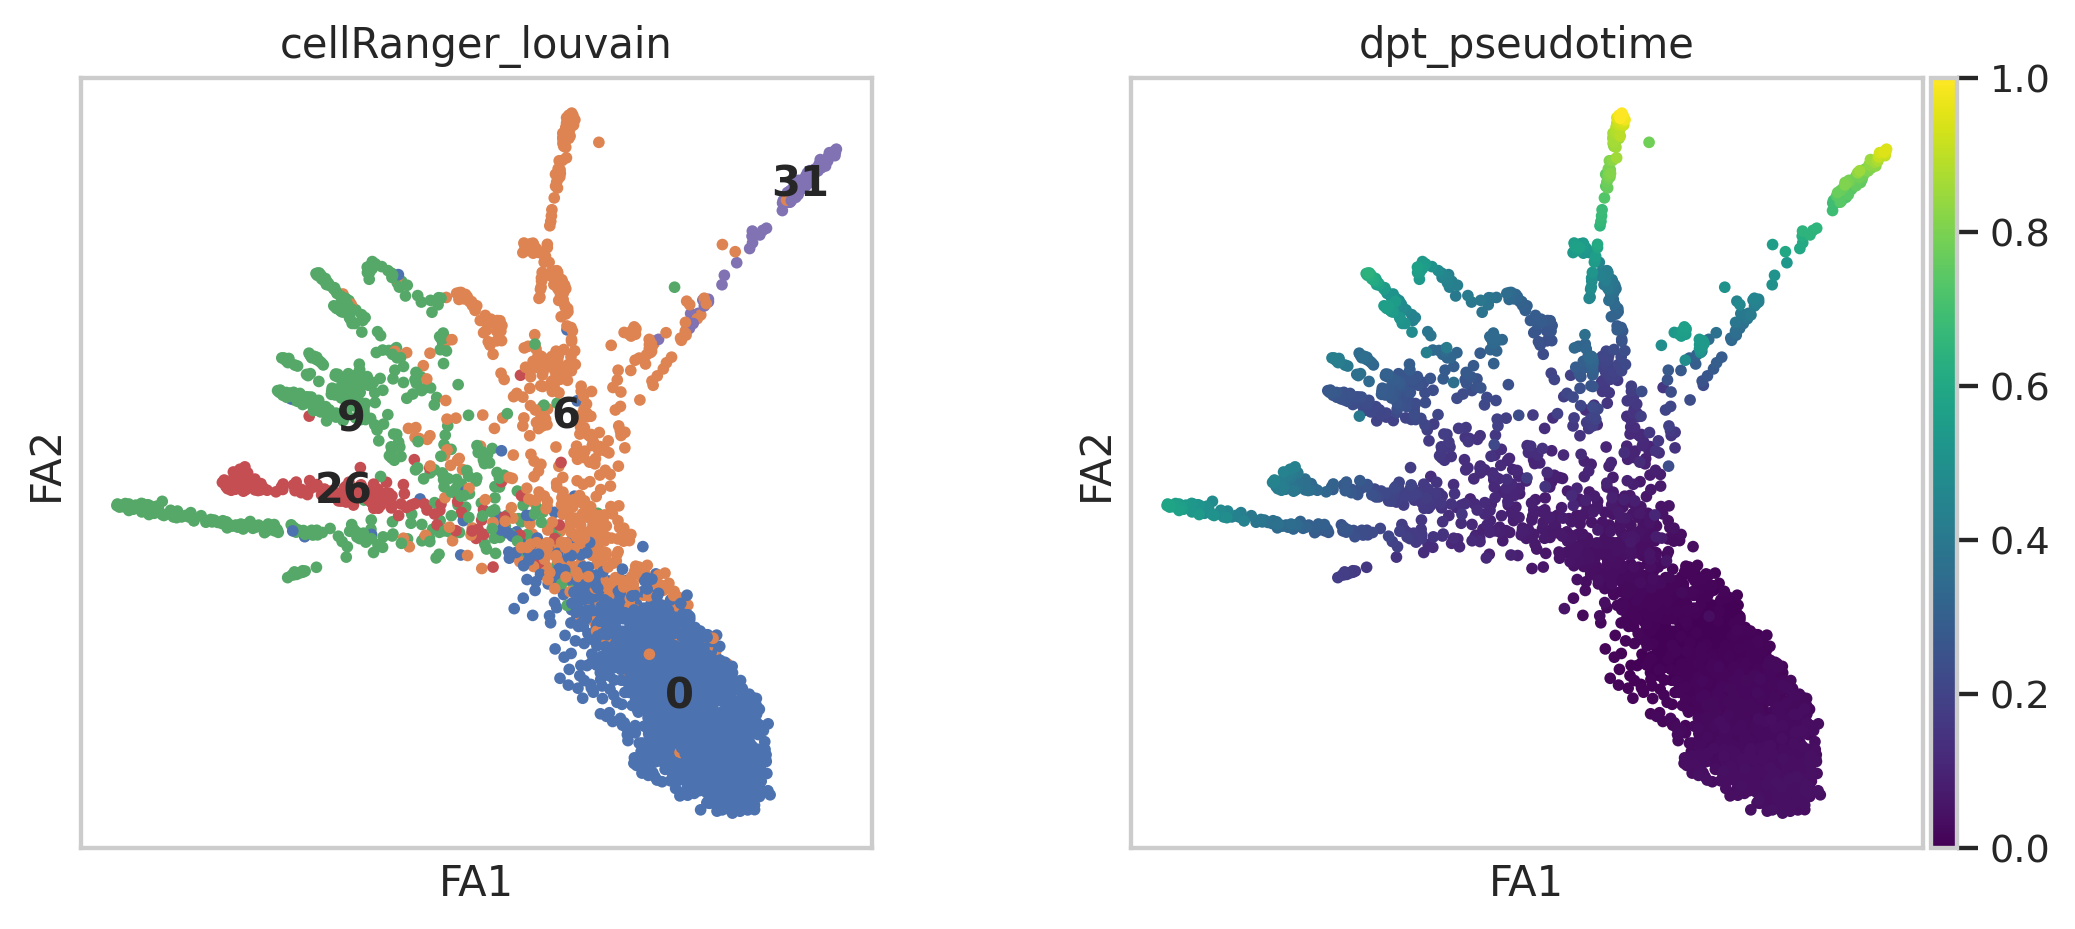

In [26]:
sc.pl.draw_graph(neur_lin_scaled, color=['cellRanger_louvain', 'dpt_pseudotime'], legend_loc='on data',color_map='viridis')

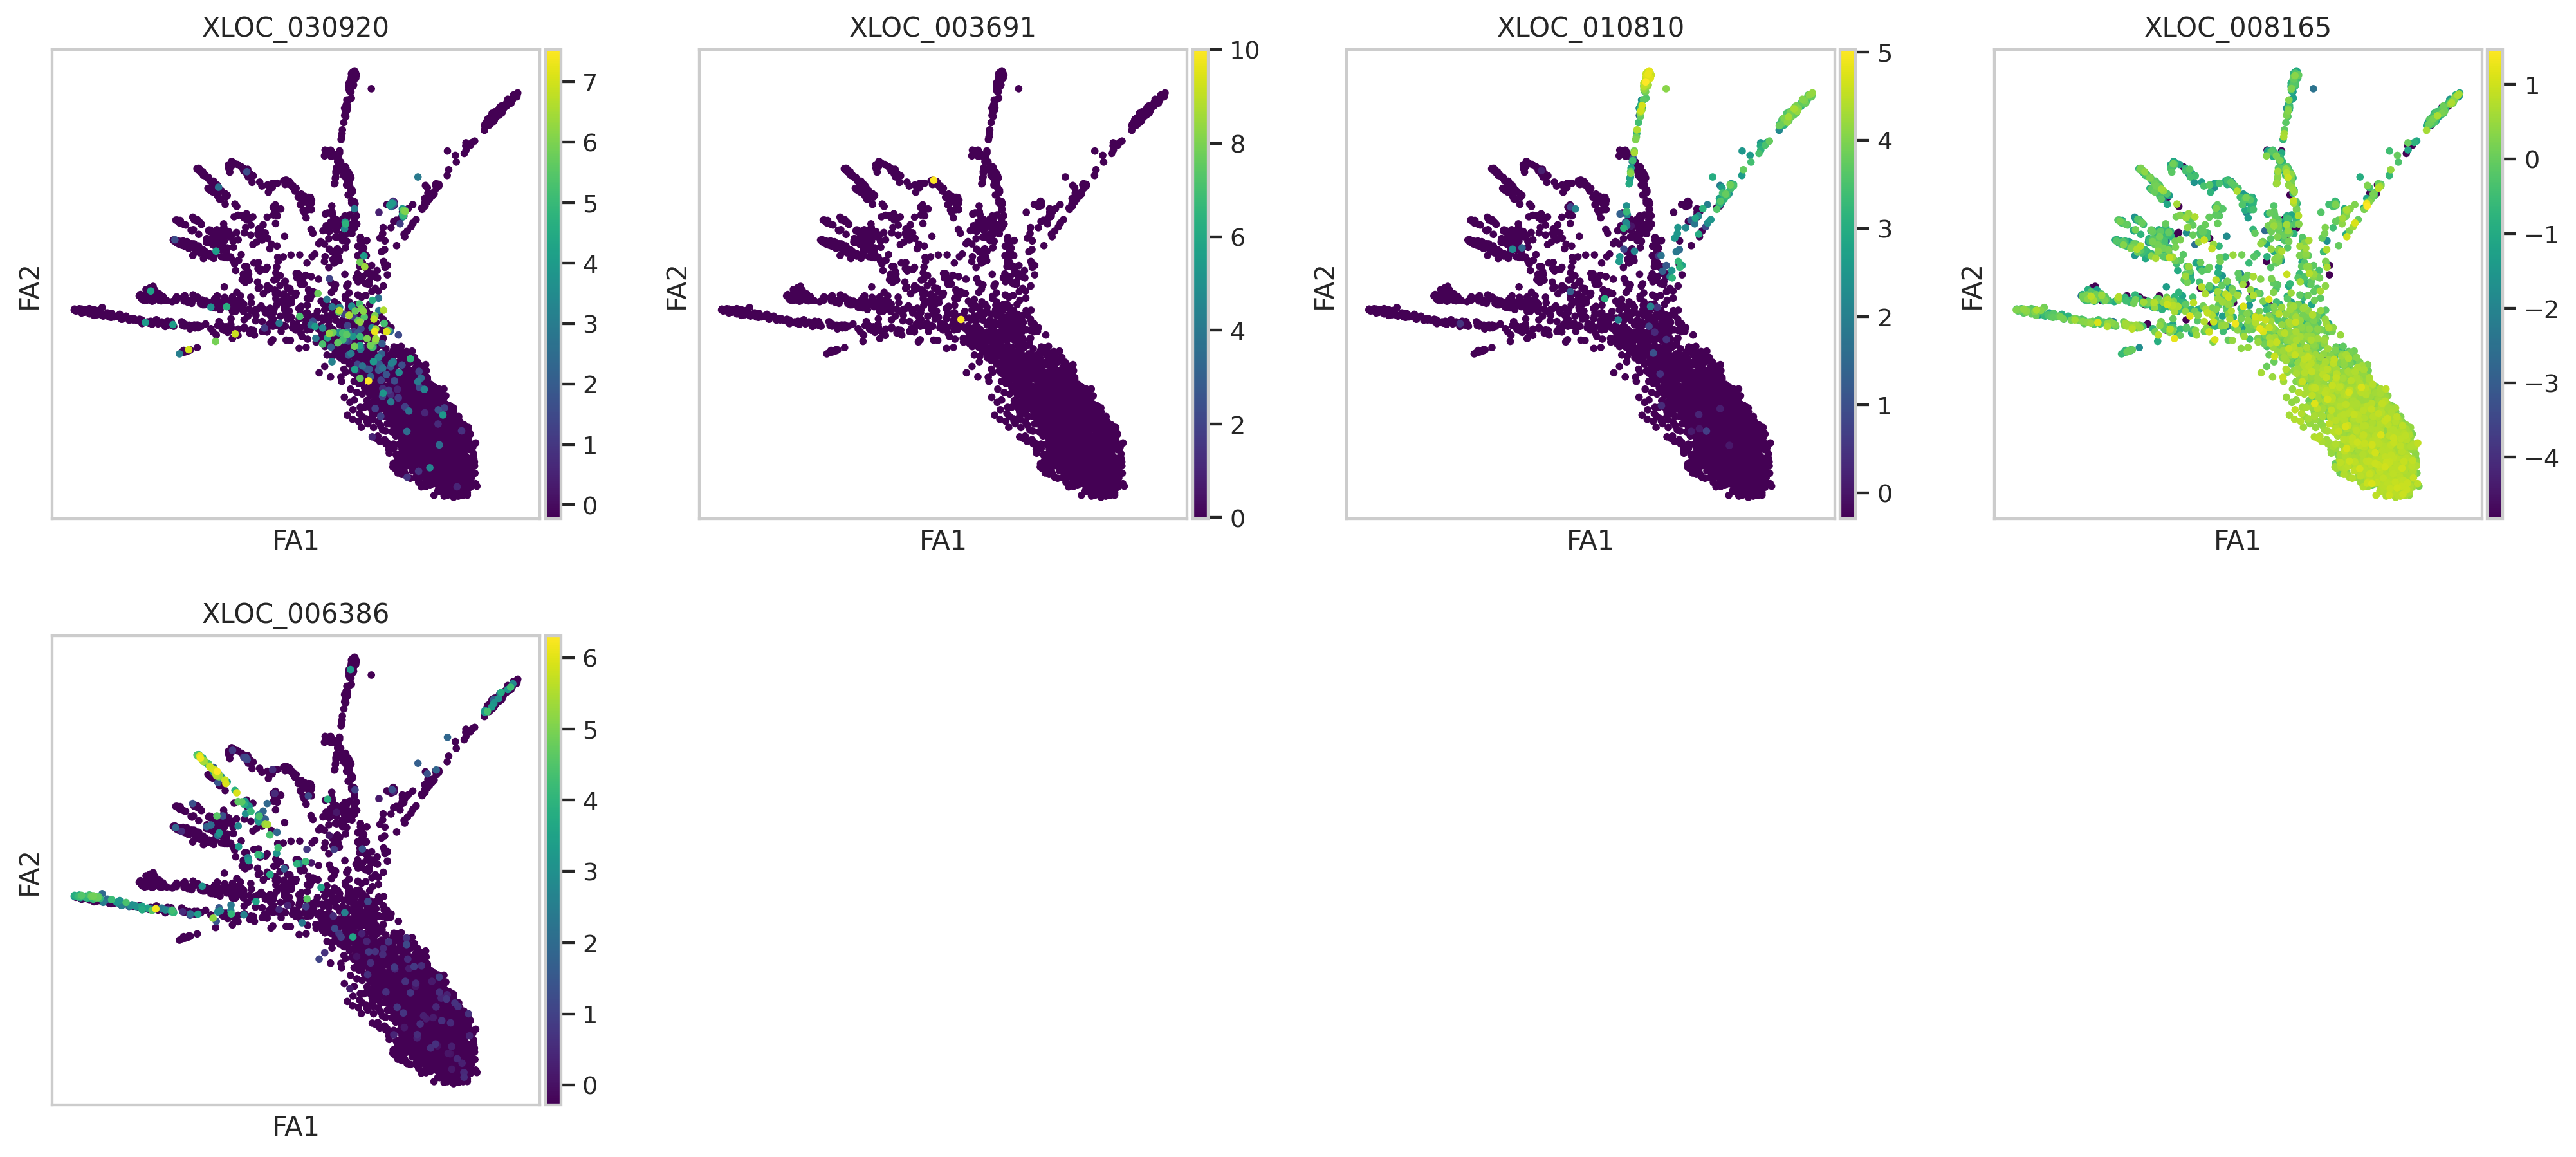

In [38]:
sc.pl.draw_graph(neur_lin_scaled, color=[ 'XLOC_030920','XLOC_003691','XLOC_010810','XLOC_008165','XLOC_006386'], 
                 legend_loc='on data',color_map='viridis')

In [32]:
#Random forest regression to determine best genes to predict pseudotime
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
X = neur_lin.X
y = neur_lin_scaled.obs['dpt_pseudotime']
regr = RandomForestRegressor(random_state=42)
regr.fit(X, y)
result = permutation_importance(regr, X, y, n_repeats=5, random_state=42)



In [41]:
neur_gene_res = pd.DataFrame()
neur_gene_res['Genes'] = neur_lin_scaled.var_names
neur_gene_res['Mean'] = result.importances_mean
neur_gene_res['Std'] = result.importances_std

neur_gene_res= neur_gene_res.sort_values('Mean', axis=0, ascending=False)

neur_gene_res= neur_gene_res[neur_gene_res.Mean > 0]

neur_gene_res.head()

,Genes,Mean,Std
546,XLOC_010810,0.542885,0.009975
411,XLOC_008165,0.095308,0.003683
330,XLOC_006386,0.046132,0.001274
1401,XLOC_033336,0.038324,0.002594
914,XLOC_019433,0.028801,0.001463


In [50]:
#Make dataframe, with 100 marker genes for each cluster + annotations

orthoGene = []
orthoDescr = []

pantherNum = []
pantherDescr = []

goTerms = []

genes = neur_gene_res.Genes

for g in genes:
        
  sub_df = hg_ortho_df[hg_ortho_df.XLOC.isin([g])]
  panth_df = panther_df[panther_df[0].isin([g])]
  go_df = goTerm_df[goTerm_df[0].isin([g])]

  if len(sub_df) > 0:
    #Save first result for gene/description
    orthoGene += [list(sub_df.Gene)[0]]
    orthoDescr += [list(sub_df.Description)[0]]
  else:
    orthoGene += ['NA']
    orthoDescr += ['NA']


  if len(panth_df) > 0:
    pantherNum += [list(panth_df[1])]
    pantherDescr += [list(panth_df[2])]
  else:
    pantherNum += ['NA']
    pantherDescr += ['NA']


  if len(go_df) > 0:
    goTerms += [list(go_df[1])]
  else:
    goTerms += ['NA']
 

neur_gene_res['orthoGene'] = orthoGene
neur_gene_res['orthoDescr'] = orthoDescr

neur_gene_res['pantherID'] = pantherNum
neur_gene_res['pantherDescr'] = pantherDescr

neur_gene_res['goTerms'] = goTerms
     
neur_gene_res.head()
#list(neurons.uns['rank_genes_groups']['names']['1'])




,Genes,Mean,Std,orthoGene,orthoDescr,pantherID,pantherDescr,goTerms
546,XLOC_010810,0.542885,0.009975,NA,NA,[PTHR10334],[CYSTEINE-RICH SECRETORY PROTEIN-RELATED],[nan]
411,XLOC_008165,0.095308,0.003683,RPL26L1,PREDICTED: 60S ribosomal protein L26-like 1 i...,[PTHR11143],[60S RIBOSOMAL PROTEIN L26 FAMILY MEMBER],"[GO:0005737,GO:0044238,GO:0005622,GO:0032991,G..."
330,XLOC_006386,0.046132,0.001274,NA,NA,[PTHR14186],[INSULIN-LIKE GROWTH FACTOR BINDING PROTEIN-RE...,[nan]
1401,XLOC_033336,0.038324,0.002594,CCDC18,PREDICTED: coiled-coil domain-containing prot...,[PTHR18875:SF11],[COILED-COIL DOMAIN-CONTAINING PROTEIN 18],[nan]
914,XLOC_019433,0.028801,0.001463,RRBP1,ribosome-binding protein 1 [Homo sapiens],[PTHR18939],[RIBOSOME BINDING PROTEIN-1],"[GO:0005737,GO:0044238,GO:0016020,GO:0032991,G..."


In [51]:
neur_gene_res.to_csv('neural_lineage_pseudotime_genes.csv')

###**I-cells, Neurons, Cnidocytes, Gland cells**

In [98]:
#Subset data

#I-cells, neurons, cnidocytes, gland cells
#Gland cells: 27,25,32,34,22
big_lin = bus_fs_raw[bus_fs_raw.obs['cellRanger_louvain'].isin([31,26,6,9,0,11,12,17,23,27,25,32,34,22])]


sc.pp.filter_cells(big_lin, min_counts=0)
sc.pp.filter_genes(big_lin, min_counts=1)
sc.pp.normalize_per_cell(big_lin, counts_per_cell_after=1e4)

sc.pp.log1p(big_lin)


sc.pp.highly_variable_genes(big_lin, n_top_genes=3000)

big_lin = big_lin[:,big_lin.var['highly_variable']]

big_lin



Trying to set attribute `.obs` of view, copying.


View of AnnData object with n_obs × n_vars = 4698 × 3000
    obs: 'batch', 'cellRanger_louvain', 'fed', 'orgID', 'n_counts'
    var: 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p'

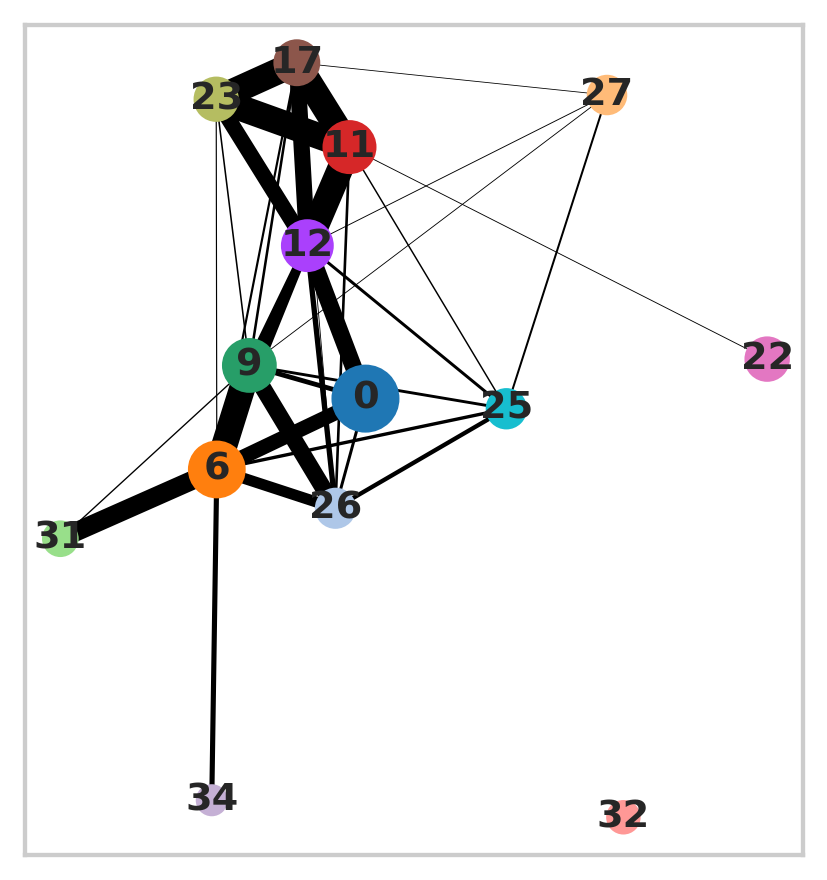

In [104]:
#Large lineage PAGA embedding
big_lin_scaled = big_lin
sc.pp.scale(big_lin_scaled, max_value=10)

sc.tl.pca(big_lin_scaled, n_comps=60)
#sc.pl.pca_variance_ratio(neur_lin_scaled, log=True)
sc.pp.neighbors(big_lin_scaled,n_neighbors=10, n_pcs=50)
big_lin_scaled.uns['iroot'] = np.flatnonzero(big_lin_scaled.obs['cellRanger_louvain']  == 0)[0]
#sc.tl.diffmap(big_lin_scaled)

sc.tl.dpt(big_lin_scaled,n_branchings = 3)
sc.pp.neighbors(big_lin_scaled, n_neighbors=20, use_rep='X_diffmap')

# #n_neighbors=5, n_pcs=15,use_rep='X_nca'
sc.tl.paga(big_lin_scaled, groups='cellRanger_louvain',)
sc.pl.paga(big_lin_scaled, color=['cellRanger_louvain'],node_size_scale=1.0
           , node_size_power=0.5, edge_width_scale=1,threshold=0.03)

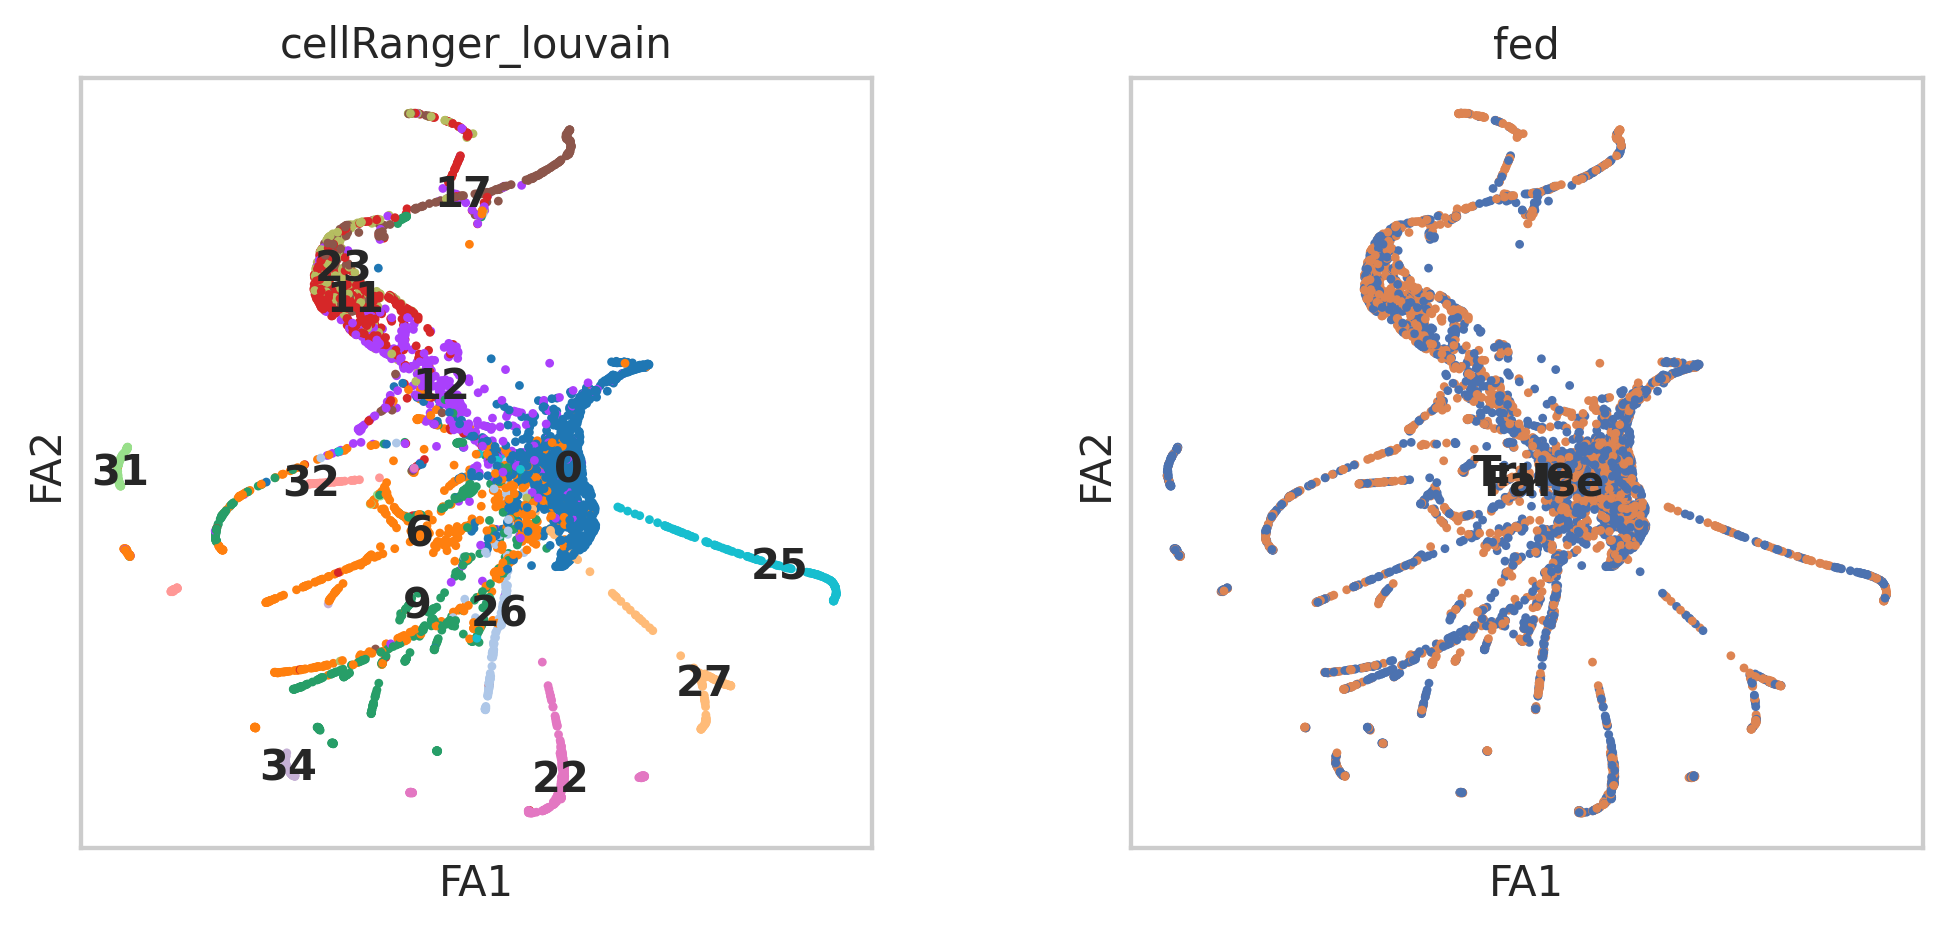

In [100]:
sc.tl.draw_graph(big_lin_scaled, init_pos='paga')
sc.pl.draw_graph(big_lin_scaled, color=['cellRanger_louvain','fed'], legend_loc='on data',color_map='viridis')

In [107]:
big_lin_scaled

AnnData object with n_obs × n_vars = 4698 × 3000
    obs: 'batch', 'cellRanger_louvain', 'fed', 'orgID', 'n_counts', 'dpt_pseudotime', 'dpt_groups', 'dpt_order', 'dpt_order_indices'
    var: 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'pca', 'neighbors', 'iroot', 'diffmap_evals', 'dpt_changepoints', 'dpt_grouptips', 'paga', 'cellRanger_louvain_sizes', 'cellRanger_louvain_colors', 'draw_graph', 'fed_colors'
    obsm: 'X_pca', 'X_diffmap', 'X_draw_graph_fa'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'